In [1]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
# 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 기본값으로 설정 (처음 5개와 마지막 5개 행만 출력)
pd.reset_option('display.max_rows')

# 출력 포맷 설정 (소수점 4자리까지)
pd.options.display.float_format = '{:.4f}'.format

import platform
import seaborn as sns

import matplotlib.pyplot as plt

# 운영 체제 확인
if platform.system() == 'Darwin':  # Mac
    print('apple gothic')
    font_name = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    font_name = 'NanumGothic'
else:
    font_name = None

# 한글 폰트 설정
if font_name:
    plt.rcParams['font.family'] = font_name

# 마이너스 부호 설정
plt.rcParams['axes.unicode_minus'] = False

apple gothic


## 데이터 로드

In [2]:
X_train = pd.read_csv('../data/dataset/X_train_scaled_std.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')
X_test = pd.read_csv('../data/dataset/X_test_scaled_std.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')

y_train = pd.read_csv('../data/dataset/y_train.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')
y_test = pd.read_csv('../data/dataset/y_test.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1187, 166), (198, 166), (1187, 1), (198, 1))

In [3]:
X_train.columns

Index(['회사명', '회계년도', 'market', '자산', '유형자산', '유동자산', '재고자산', '자본', '매출액',
       '매출원가',
       ...
       '기업실사BSI_실적', '기업실사BSI_전망', '매출액정상영업이익률', '매출액순이익률', '매출액총이익률',
       '총자본순이익률', '총자본사업이익률', '총자본정상영업이익률', '자기자본정상영업이익률', '자기자본순이익률'],
      dtype='object', length=166)

## 후보피처

In [4]:
# 정보 변수
cols_info = ['회사명', '회계년도']

cols_nonfeature = cols_info

In [5]:
# 범주형 변수
cols_cate = ['manuf_GB', 'market']

# 연속형 변수
cols_num = X_train.drop(columns=cols_info+cols_cate).columns

X_train.shape, len(cols_info), len(cols_cate), len(cols_num)

((1187, 166), 2, 2, 162)

In [6]:
X_train.index.equals(y_train.index)

True

In [7]:
X_test.index.equals(y_test.index)

True

In [8]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.shape, test.shape

((1187, 167), (198, 167))

In [9]:
X_TRAIN = X_train.copy()
X_TEST = X_test.copy()

X_TRAIN.shape, X_TEST.shape

((1187, 166), (198, 166))

In [10]:
train.columns.difference(cols_info)

Index(['(투자활동으로 인한 현금유출액)', '1인당매출액', '1인당인건비', 'CB_spread(AA-)',
       'CB_spread(BBB-)', 'CCI(경기동행)', 'CLI(경기선행)', 'CPI_sticky', 'Core_CPI',
       'Core_PCE',
       ...
       '총자본순이익률', '총자본정상영업이익률', '총자산회전율', '토지', '퇴직급여', '투자안정성비율',
       '투자활동으로 인한 현금유입액', '판매비와 관리비(물류원가 등 포함)', '현금및현금성자산', '현금비율'],
      dtype='object', length=165)

In [11]:
# # 정보형 변수 제거
# X_train.drop(columns = cols_info, inplace=True)
# X_test.drop(columns = cols_info, inplace=True)

# train.drop(columns = cols_info, inplace=True)
# test.drop(columns = cols_info, inplace=True)

# X_train.shape, X_test.shape, train.shape, test.shape

## Feature Selection

### (1) Filter

- 통계기법 사용하여 변수를 선택하는 방법
- 전처리단에서 주로 사용할 만 하며 통계기법을 사용하여 상관관계가 높은 변수나, 성능이 높은 변수를 추출하는 방법

In [12]:
from modules import feature_selection as fs

In [13]:
cols_feature = train.columns.difference(cols_info).tolist()
len(cols_feature)

165

In [14]:
'label' in cols_feature

True

In [15]:
ttest = fs.selection_ttest(
    train, 'label', cols_feature=cols_feature, pvalue=0.05
)

후보 피처 수 :  164
유의한 피쳐 수 : 70


In [16]:
ttest

,변수,분산,p_value
155,총자본정상영업이익률,hetero,0.0000
153,총자본사업이익률,hetero,0.0000
74,변동비대비매출액,hetero,0.0000
154,총자본순이익률,hetero,0.0000
128,자기자본순이익률,hetero,0.0000
...,...,...,...
115,유무형자산,homo,0.0450
22,TB_rtn(1y),homo,0.0457
80,비유동자산,homo,0.0477
131,자본,hetero,0.0481


In [17]:
X_train['변동비대비매출액'].describe()

count   1187.0000
mean       0.0000
std        1.0004
min       -2.0072
25%       -0.4222
50%       -0.2479
75%        0.0288
max        7.0613
Name: 변동비대비매출액, dtype: float64

### (2) Wrapper

- Forward Selection(전진 선택)
  - 변수가 없는 상태로 시작하며 반복할 때마다 가장 중요한 변수를 추가하여 더 이상 성능의 향상이 없을 때까지 변수를 추가한다.
- **Backward Elimination(후방 제거)**
  - 모든 변수를 가지고 시작하며, 가장 덜 중요한 변수를 하나씩 제거하면서 모델의 성능을 향상시킨다. 더 이상 성능의 향상이 없을 때까지 반복한다.
- Stepwise Selection(단계별 선택)
  - Foward Selection 과 Backward Elimination 을 결합하여 사용하는 방식으로, 모든  변수를 가지고 시작하여 가장 도움이 되지 않는 변수를 삭제하거나, 모델에서 빠져있는 변수 중에서 가장 중요한 변수를 추가하는 방법이다. 이와 같이 변수를 추가 또는 삭제를 반복한다. 반대로 아무것도 없는 모델에서 출발해 변수를 추가, 삭제를 반복할 수도 있다.

In [18]:
cols_feature_back = X_train.columns.difference(cols_info).tolist()

backward = fs.selection_backward(
    X_train, y_train, X_train, y_train,
    # X_train, y_train, X_test, y_test,
    cols_feature_back, base_model_name='lr'
)

len(backward), backward[:10]

Removed feature: 기타무형자산상각비, Accuracy: 0.7254

Final selected features:
선택된 피처 수: 163


(163,
 ['(투자활동으로 인한 현금유출액)',
  '1인당매출액',
  '1인당인건비',
  'CB_spread(AA-)',
  'CB_spread(BBB-)',
  'CCI(경기동행)',
  'CLI(경기선행)',
  'CPI_sticky',
  'Core_CPI',
  'Core_PCE'])

### (3) Logit

#### Logit

In [19]:
logit = fs.selection_logit(
    X_train.drop(columns=cols_info),
    y_train,
)

# pvalue > 0.05 이상이면 다 나옴
# Q&A ? 로지스틱 회귀에서 
# 회귀에서 통계량 -> t-test
# wald 통계량 

# lasso vs logit
# lasso -> 회귀모형에서 나오는 경사하강법에서 가중치 왼쪽에 주냐 오른쪽에 주냐 : 규제로 개수 조절 가능
# logit -> wald 통계량으로 pvalue 계산 : 개수 정해짐

Logit으로 선택된 피처 수:  62


In [20]:
len(logit), logit[:10]

(62,
 ['market',
  '유동자산',
  '재고자산',
  '자본',
  '매출액',
  '판매비와 관리비(물류원가 등 포함)',
  '외화환산이익1',
  '외환차손1',
  '건설중인자산',
  '토지'])

### Filter + Wrapper + Logit --> `selected_features`

In [21]:
selected = ttest.copy()
selected.set_index('변수', inplace=True)
selected

,분산,p_value
변수,,
총자본정상영업이익률,hetero,0.0000
총자본사업이익률,hetero,0.0000
변동비대비매출액,hetero,0.0000
총자본순이익률,hetero,0.0000
자기자본순이익률,hetero,0.0000
...,...,...
유무형자산,homo,0.0450
TB_rtn(1y),homo,0.0457
비유동자산,homo,0.0477


In [22]:
for fea in selected.index:
    if fea in backward:
        selected.loc[fea, 'backward'] = True
    if fea in logit:
        selected.loc[fea, 'logit'] = True

In [23]:
selected[(selected['backward']) & (selected['logit'])]

,분산,p_value,backward,logit
변수,,,,
총자본정상영업이익률,hetero,0.0000,True,True
변동비대비매출액,hetero,0.0000,True,True
총자본순이익률,hetero,0.0000,True,True
자기자본순이익률,hetero,0.0000,True,True
매출액순이익률,hetero,0.0000,True,True
총자산회전율,hetero,0.0000,True,True
매출액,hetero,0.0000,True,True
매출채권 및 기타유동채권,homo,0.0000,True,True
순운전자본(민식),homo,0.0000,True,True


In [24]:
selected_features = selected[(selected['backward']) & (selected['logit'])].index.tolist()
len(selected_features), selected_features

(28,
 ['총자본정상영업이익률',
  '변동비대비매출액',
  '총자본순이익률',
  '자기자본순이익률',
  '매출액순이익률',
  '총자산회전율',
  '매출액',
  '매출채권 및 기타유동채권',
  '순운전자본(민식)',
  '매출채권',
  '변동비',
  '총비용',
  '비유동장기적합률',
  '미처분이익잉여금(결손금)',
  '유동자산',
  '비유동비율',
  '자기자본비율',
  '비유동부채비율',
  '매출액정상영업이익률',
  '당좌비율',
  '판매비와 관리비(물류원가 등 포함)',
  '영업손익',
  '자본금회전율',
  '연구개발비',
  '순운전자본대비총자본',
  '비유동자산',
  '자본',
  '배당금지급(-)'])

In [77]:
selected_final = selected[(selected['backward']) & (selected['logit'])].reset_index()
selected_final

,변수,분산,p_value,backward,logit
0,총자본정상영업이익률,hetero,0.0000,True,True
1,변동비대비매출액,hetero,0.0000,True,True
2,총자본순이익률,hetero,0.0000,True,True
3,자기자본순이익률,hetero,0.0000,True,True
4,매출액순이익률,hetero,0.0000,True,True
5,총자산회전율,hetero,0.0000,True,True
6,매출액,hetero,0.0000,True,True
7,매출채권 및 기타유동채권,homo,0.0000,True,True
8,순운전자본(민식),homo,0.0000,True,True
9,매출채권,homo,0.0000,True,True


In [92]:
train.loc[train['label']==1, selected_features].describe()

,총자본정상영업이익률,변동비대비매출액,총자본순이익률,자기자본순이익률,매출액순이익률,총자산회전율,매출액,매출채권 및 기타유동채권,순운전자본(민식),매출채권,변동비,총비용,비유동장기적합률,미처분이익잉여금(결손금),유동자산,비유동비율,자기자본비율,비유동부채비율,매출액정상영업이익률,당좌비율,판매비와 관리비(물류원가 등 포함),영업손익,자본금회전율,연구개발비,순운전자본대비총자본,비유동자산,자본,배당금지급(-)
count,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000,409.0000
mean,0.2611,-0.2242,0.2478,0.2193,0.2017,0.2412,8.1430,7.4463,7.7098,7.4661,8.1029,8.1593,-0.1455,0.1514,7.9303,-0.1202,0.1245,-0.1133,0.0900,-0.0988,7.3268,0.1000,0.0996,0.1131,0.0867,7.9267,0.0890,0.0888
std,0.7152,0.4274,0.6936,0.6223,0.4534,1.0534,0.6602,0.6926,0.6432,0.6905,0.6473,0.6430,0.8185,1.1031,0.5868,0.8631,0.9592,0.8104,0.0674,0.6327,0.5773,0.8332,0.9839,1.3279,0.9579,0.6782,1.2450,1.2493
min,-4.5463,-2.0072,-3.1533,-7.5136,-5.3380,-1.6118,6.5382,5.1793,6.0530,5.1793,6.6117,6.7454,-1.6409,-6.2114,6.2542,-1.0448,-2.3250,-0.6066,-0.4232,-0.4049,6.2979,-5.6806,-0.6868,-0.2538,-0.8600,6.3305,-0.2984,-0.2343
25%,0.1016,-0.4516,0.0390,0.1156,0.1829,-0.5324,7.6904,6.9987,7.2891,7.0092,7.6584,7.7242,-0.7032,-0.1583,7.5362,-0.5583,-0.6031,-0.5239,0.0877,-0.3611,6.9169,0.1021,-0.4546,-0.2538,-0.8600,7.4746,-0.2571,-0.2343
50%,0.4835,-0.3051,0.3790,0.3440,0.2744,0.0528,8.0778,7.3921,7.6563,7.3949,8.0239,8.0785,-0.2532,-0.0815,7.8187,-0.3228,0.1036,-0.3305,0.1119,-0.2953,7.2141,0.1526,-0.2394,-0.2112,-0.1269,7.8050,-0.2167,-0.2180
75%,0.6840,-0.1444,0.5893,0.4606,0.3183,0.7470,8.5488,7.8527,8.0876,7.8779,8.5075,8.5528,0.2686,0.1438,8.2199,0.0623,0.8972,0.0656,0.1211,-0.1059,7.6490,0.1956,0.2229,-0.0851,0.7200,8.3049,-0.1046,-0.1279
max,1.1852,3.3009,4.3237,2.4009,3.1056,3.5447,10.1045,9.5292,9.7358,9.5608,10.0470,10.0942,5.0454,7.0966,9.8419,6.2979,2.0859,6.7270,0.1625,6.8449,9.1199,6.5804,5.6564,8.3706,3.0945,10.0978,7.9422,8.3936


In [93]:
train.loc[train['label']==0, selected_features].describe()

,총자본정상영업이익률,변동비대비매출액,총자본순이익률,자기자본순이익률,매출액순이익률,총자산회전율,매출액,매출채권 및 기타유동채권,순운전자본(민식),매출채권,변동비,총비용,비유동장기적합률,미처분이익잉여금(결손금),유동자산,비유동비율,자기자본비율,비유동부채비율,매출액정상영업이익률,당좌비율,판매비와 관리비(물류원가 등 포함),영업손익,자본금회전율,연구개발비,순운전자본대비총자본,비유동자산,자본,배당금지급(-)
count,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000,778.0000
mean,-0.1373,0.1178,-0.1303,-0.1153,-0.1060,-0.1268,7.9358,7.2468,7.5237,7.2772,7.9277,7.9877,0.0765,-0.0796,7.8065,0.0632,-0.0655,0.0596,-0.0473,0.0519,7.2297,-0.0526,-0.0523,-0.0594,-0.0456,7.8443,-0.0468,-0.0467
std,1.0974,1.1796,1.1071,1.1339,1.1777,0.9478,0.7214,0.7301,0.6974,0.7186,0.6752,0.6695,1.0765,0.9329,0.5926,1.0606,1.0159,1.0828,1.2324,1.1444,0.5572,1.0748,1.0057,0.7691,1.0197,0.6828,0.8411,0.8377
min,-5.3785,-1.6444,-5.2339,-7.5136,-9.1443,-1.7269,5.1090,4.2929,4.8221,4.2929,6.5420,6.5988,-1.7937,-6.2114,6.3487,-1.0448,-2.3250,-0.6066,-30.9405,-0.4050,6.0463,-8.0748,-0.6959,-0.2538,-0.8600,5.2321,-0.2984,-0.2343
25%,-0.5393,-0.3877,-0.4812,-0.2182,-0.0249,-0.7917,7.4728,6.8116,7.0763,6.8288,7.4584,7.5154,-0.5982,-0.2090,7.4126,-0.4805,-0.7414,-0.5042,0.0314,-0.3606,6.8535,0.0322,-0.5574,-0.2538,-0.8600,7.4033,-0.2645,-0.2343
50%,0.2106,-0.1969,0.1898,0.2276,0.2038,-0.2648,7.8670,7.1969,7.4905,7.2323,7.8448,7.8940,-0.0176,-0.1345,7.7073,-0.1933,-0.1359,-0.2706,0.0934,-0.2972,7.1334,0.1273,-0.3700,-0.2288,-0.5031,7.7689,-0.2382,-0.2343
75%,0.6036,0.1261,0.4928,0.4051,0.2928,0.3961,8.3122,7.6183,7.8965,7.6304,8.2802,8.3315,0.4603,-0.0241,8.0860,0.2528,0.6031,0.1711,0.1172,-0.1287,7.4958,0.1768,0.0100,-0.1253,0.5192,8.1877,-0.1630,-0.1609
max,1.1852,7.0613,4.3237,2.4009,3.1056,3.5447,10.1045,9.5292,9.7358,9.5608,10.0470,10.0942,5.0454,7.0966,9.8419,6.2979,2.1907,6.7270,0.1820,6.8449,9.1199,6.5804,5.6564,8.3706,3.0945,10.0978,7.9422,8.3936


## 최종 피처 선택

1. vif 제일 높은 피처 1개 선택
2. (1)에서 고른 피처와 상관계수 높은 피처 확인
3. (1, 2)에서 고른 피처 중 ttest pvalue 가장 낮은 피처 하나 선택

<!-- 4. ttest pvalue 작은 순서대로
   - pvalue가 낮음 = t통계량이 매우 큼 = 평균의 차이가 매우 큼
   - 통계량의 식을 확인해야함. 분모에 티통계량이 들어가고, 커질수록 피값이 낮아지는것임. 

5. 상관계수 고려
6. lasso 페널티 세게 했을 때 나온 피처 확인 -->

In [78]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(data):

    # VIF 출력을 위한 데이터 프레임 형성
    vif = pd.DataFrame()

    # VIF 값과 각 Feature 이름에 대해 설정
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    vif["features"] = data.columns 
                    
    # VIF 값이 높은 순으로 정렬
    vif = vif.sort_values(by="VIF Factor", ascending=False)
    vif = vif.reset_index().drop(columns='index')
    
    return vif

In [79]:
len(selected_features)

28

In [80]:
selected_final = selected_final.set_index('변수')
selected_final.head()

,분산,p_value,backward,logit
변수,,,,
총자본정상영업이익률,hetero,0.0000,True,True
변동비대비매출액,hetero,0.0000,True,True
총자본순이익률,hetero,0.0000,True,True
자기자본순이익률,hetero,0.0000,True,True
매출액순이익률,hetero,0.0000,True,True


In [81]:
vifs = vif(X_train[selected_features]).set_index('features')
for feature in vifs.index:
    selected_final.loc[feature, 'vif'] = vifs.loc[feature, 'VIF Factor']

selected_final

,분산,p_value,backward,logit,vif
변수,,,,,
총자본정상영업이익률,hetero,0.0000,True,True,7.7404
변동비대비매출액,hetero,0.0000,True,True,23.3570
총자본순이익률,hetero,0.0000,True,True,7.1028
자기자본순이익률,hetero,0.0000,True,True,3.8538
매출액순이익률,hetero,0.0000,True,True,12.2894
총자산회전율,hetero,0.0000,True,True,6.6345
매출액,hetero,0.0000,True,True,386938.3643
매출채권 및 기타유동채권,homo,0.0000,True,True,14260.1903
순운전자본(민식),homo,0.0000,True,True,2908.8392


In [82]:
selected_final.sort_values('vif', ascending=False).head()

,분산,p_value,backward,logit,vif
변수,,,,,
매출액,hetero,0.0000,True,True,386938.3643
총비용,homo,0.0000,True,True,246021.9101
변동비,homo,0.0000,True,True,243428.3118
매출채권,homo,0.0000,True,True,15206.2865
매출채권 및 기타유동채권,homo,0.0000,True,True,14260.1903


28 Index(['매출액', '총비용', '변동비', '매출채권', '매출채권 및 기타유동채권', '유동자산', '비유동자산',
       '순운전자본(민식)', '판매비와 관리비(물류원가 등 포함)', '변동비대비매출액', '매출액순이익률', '비유동비율',
       '비유동부채비율', '매출액정상영업이익률', '비유동장기적합률', '총자본정상영업이익률', '순운전자본대비총자본',
       '자기자본비율', '총자본순이익률', '총자산회전율', '자본', '자기자본순이익률', '배당금지급(-)', '당좌비율',
       '연구개발비', '미처분이익잉여금(결손금)', '자본금회전율', '영업손익'],
      dtype='object', name='변수')


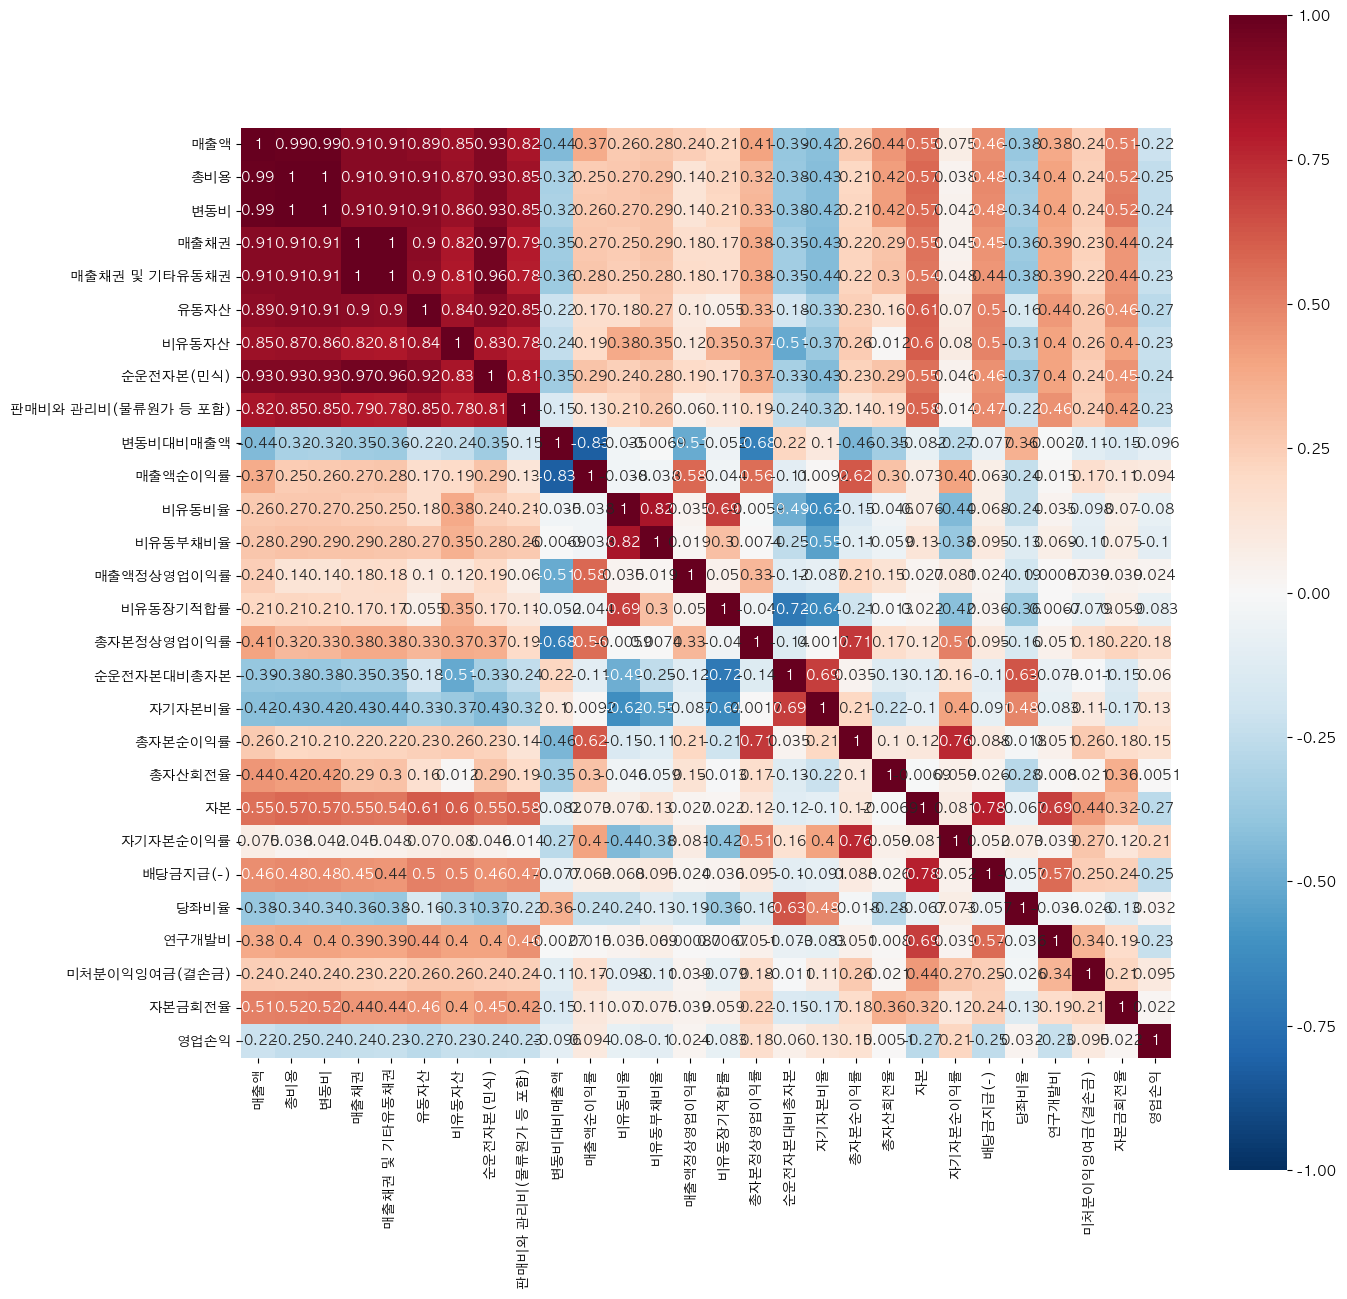

In [85]:
# vif 높은 순서대로 정렬
features = selected_final.sort_values('vif', ascending=False).index
print(len(features), features)

# 상관계수 히트맵
plt.figure(figsize=(15, 15))
sns.heatmap(
    X_train[features].corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [86]:
selected_final.loc[['매출액', '총비용', '변동비', '매출채권', '매출채권 및 기타유동채권', '유동자산', '비유동자산', '순운전자본(민식)', '판매비와 관리비(물류원가 등 포함)']].sort_values('p_value')

,분산,p_value,backward,logit,vif
변수,,,,,
매출액,hetero,0.0000,True,True,386938.3643
매출채권 및 기타유동채권,homo,0.0000,True,True,14260.1903
순운전자본(민식),homo,0.0000,True,True,2908.8392
매출채권,homo,0.0000,True,True,15206.2865
변동비,homo,0.0000,True,True,243428.3118
총비용,homo,0.0000,True,True,246021.9101
유동자산,homo,0.0006,True,True,4873.8854
판매비와 관리비(물류원가 등 포함),homo,0.0049,True,True,775.2058
비유동자산,homo,0.0477,True,True,4062.8577


In [87]:
vifs = vif(X_train[features].drop(columns=['비유동자산', '판매비와 관리비(물류원가 등 포함)', '유동자산', '총비용', '변동비', '매출채권', '순운전자본(민식)', '매출채권 및 기타유동채권']))

vifs

,VIF Factor,features
0,9.7831,비유동비율
1,7.0669,비유동부채비율
2,6.4010,매출액순이익률
3,6.2118,변동비대비매출액
4,6.0357,비유동장기적합률
5,5.4003,총자본순이익률
6,4.1514,자본
7,4.0637,총자본정상영업이익률
8,3.8614,순운전자본대비총자본
9,3.5878,자기자본순이익률


20 ['비유동비율', '비유동부채비율', '매출액순이익률', '변동비대비매출액', '비유동장기적합률', '총자본순이익률', '자본', '총자본정상영업이익률', '순운전자본대비총자본', '자기자본순이익률', '자기자본비율', '배당금지급(-)', '당좌비율', '연구개발비', '매출액정상영업이익률', '총자산회전율', '미처분이익잉여금(결손금)', '자본금회전율', '영업손익', '매출액']


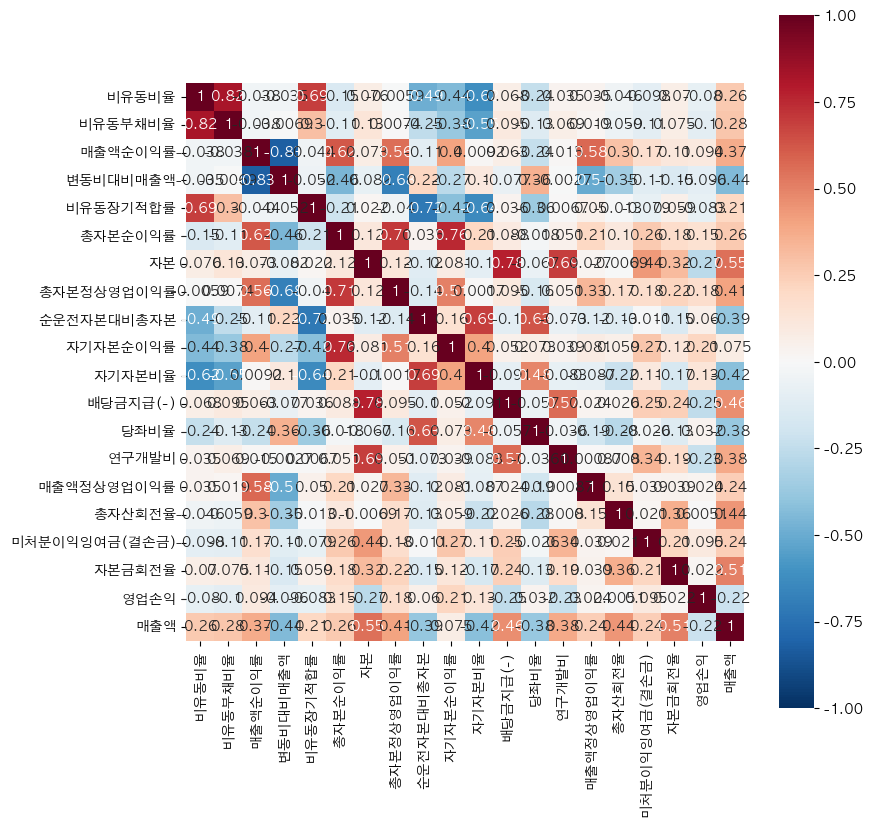

In [88]:
# vif 높은 순서대로 정렬
features = vifs['features'].tolist()
print(len(features), features)

# 상관계수 히트맵
plt.figure(figsize=(9, 9))
sns.heatmap(
    X_train[features].corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [98]:
vifs[vifs['features'].isin(['비유동비율', '비유동부채비율', '비유동장기적합률', '자기자본비율'])]

,VIF Factor,features
0,9.7831,비유동비율
1,7.0669,비유동부채비율
4,6.0357,비유동장기적합률
10,3.5647,자기자본비율


In [89]:
selected_final.loc[['비유동비율', '비유동부채비율', '비유동장기적합률', '자기자본비율']].sort_values('p_value')

,분산,p_value,backward,logit,vif
변수,,,,,
비유동장기적합률,hetero,0.0001,True,True,7.9808
비유동비율,hetero,0.0014,True,True,10.3916
자기자본비율,homo,0.0018,True,True,7.2663
비유동부채비율,hetero,0.0020,True,True,9.0841


In [100]:
vifs = vif(X_train[features].drop(columns=['비유동부채비율', '자기자본비율', '비유동비율']))

vifs

,VIF Factor,features
0,6.3732,매출액순이익률
1,6.1691,변동비대비매출액
2,5.2719,총자본순이익률
3,4.0796,자본
4,4.0166,총자본정상영업이익률
5,3.3481,순운전자본대비총자본
6,3.0244,자기자본순이익률
7,2.7625,비유동장기적합률
8,2.6384,배당금지급(-)
9,1.9708,당좌비율


15

17 ['매출액순이익률', '변동비대비매출액', '총자본순이익률', '자본', '총자본정상영업이익률', '순운전자본대비총자본', '자기자본순이익률', '비유동장기적합률', '배당금지급(-)', '당좌비율', '연구개발비', '매출액정상영업이익률', '미처분이익잉여금(결손금)', '총자산회전율', '자본금회전율', '영업손익', '매출액']


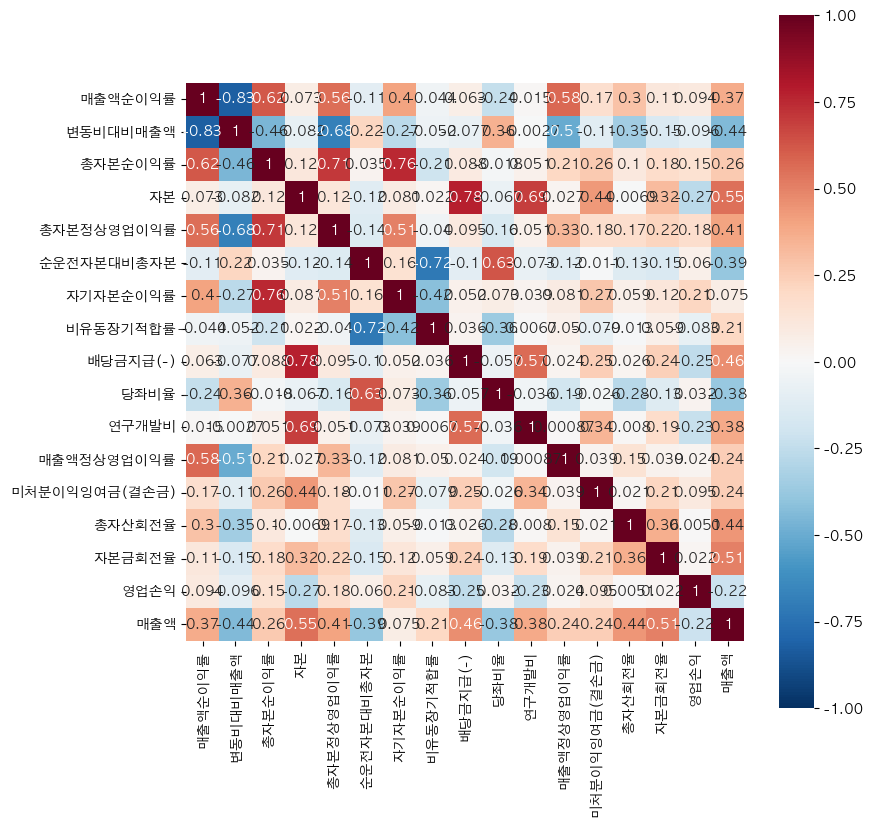

In [101]:
# vif 높은 순서대로 정렬
features = vifs['features'].tolist()
print(len(features), features)

# 상관계수 히트맵
plt.figure(figsize=(9, 9))
sns.heatmap(
    X_train[features].corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [105]:
selected_final.loc[['매출액순이익률', '변동비대비매출액', '총자본순이익률', '총자본정상영업이익률', '매출액정상영업이익률']].sort_values('p_value')

,분산,p_value,backward,logit,vif
변수,,,,,
총자본정상영업이익률,hetero,0.0000,True,True,7.7404
변동비대비매출액,hetero,0.0000,True,True,23.3570
총자본순이익률,hetero,0.0000,True,True,7.1028
매출액순이익률,hetero,0.0000,True,True,12.2894
매출액정상영업이익률,hetero,0.0020,True,True,8.6214


In [112]:
vifs = vif(X_train[features].drop(columns=['매출액정상영업이익률', '매출액순이익률']))
vifs

KeyError: "['매출액정상영업이익률', '매출액순이익률'] not found in axis"

In [114]:
vifs = vif(X_train[features].drop(columns=['총자본순이익률', '변동비대비매출액']))
vifs

,VIF Factor,features
0,4.0697,자본
1,3.3052,순운전자본대비총자본
2,2.7166,비유동장기적합률
3,2.6365,배당금지급(-)
4,1.9521,연구개발비
5,1.8536,자기자본순이익률
6,1.8383,당좌비율
7,1.5196,총자본정상영업이익률
8,1.4351,미처분이익잉여금(결손금)
9,1.3649,자본금회전율


13 ['자본', '순운전자본대비총자본', '비유동장기적합률', '배당금지급(-)', '연구개발비', '자기자본순이익률', '당좌비율', '총자본정상영업이익률', '미처분이익잉여금(결손금)', '자본금회전율', '총자산회전율', '영업손익', '매출액']


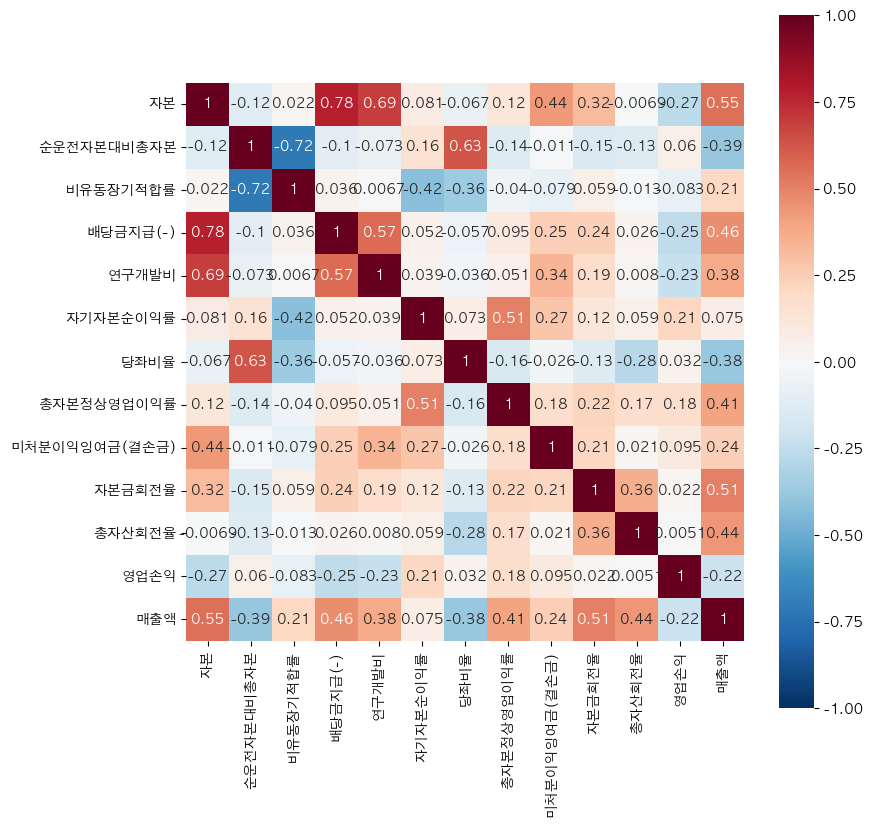

In [117]:
# vif 높은 순서대로 정렬
features = vifs['features'].tolist()
print(len(features), features)

# 상관계수 히트맵
plt.figure(figsize=(9, 9))
sns.heatmap(
    # X_train[features].drop(columns=['자본']).corr(),
    X_train[features].corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [118]:
selected_final.loc[['자본', '배당금지급(-)', '연구개발비', '매출액']].sort_values('p_value')

,분산,p_value,backward,logit,vif
변수,,,,,
매출액,hetero,0.0000,True,True,386938.3643
연구개발비,hetero,0.0157,True,True,2.0444
자본,hetero,0.0481,True,True,4.2018
배당금지급(-),hetero,0.0491,True,True,2.6628


In [125]:
# vifs = vif(X_train[features].drop(columns=['총자본순이익률', '변동비대비매출액']))
# vifs
# '배당급지급(-)', 
vifs = vif(X_train[features].drop(columns=['자본', '연구개발비']))
vifs

,VIF Factor,features
0,3.2782,순운전자본대비총자본
1,2.6956,비유동장기적합률
2,1.8473,자기자본순이익률
3,1.8377,당좌비율
4,1.5155,총자본정상영업이익률
5,1.3023,자본금회전율
6,1.2763,총자산회전율
7,1.2300,배당금지급(-)
8,1.1909,미처분이익잉여금(결손금)
9,1.1624,영업손익


11 ['순운전자본대비총자본', '비유동장기적합률', '자기자본순이익률', '당좌비율', '총자본정상영업이익률', '자본금회전율', '총자산회전율', '배당금지급(-)', '미처분이익잉여금(결손금)', '영업손익', '매출액']


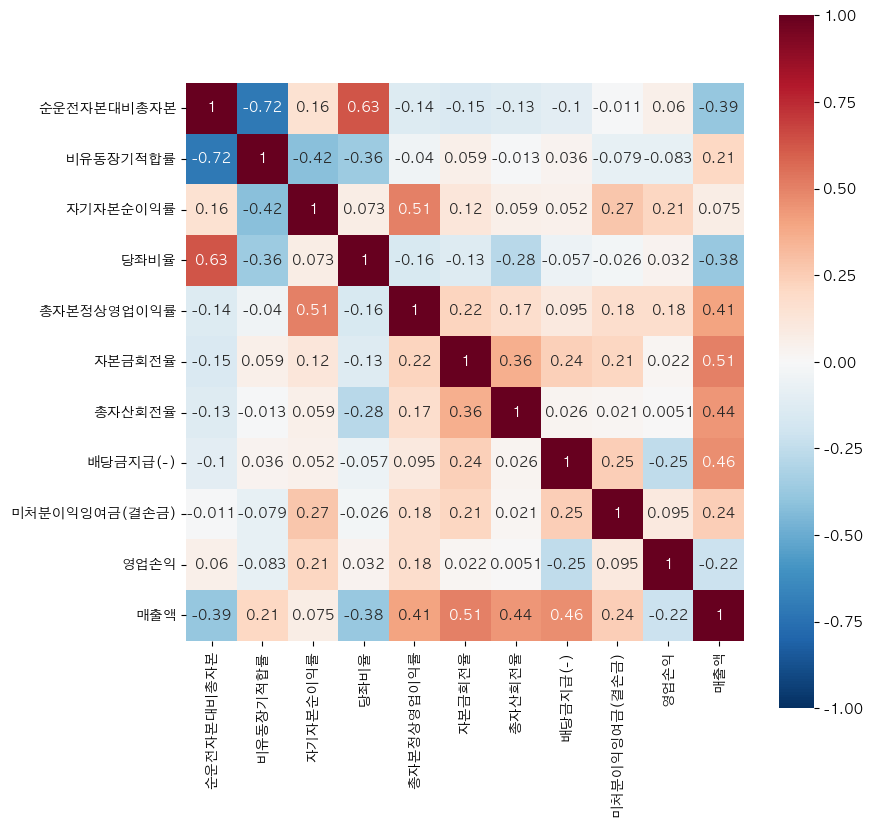

In [126]:
# vif 높은 순서대로 정렬
features = vifs['features'].tolist()
print(len(features), features)

# 상관계수 히트맵
plt.figure(figsize=(9, 9))
sns.heatmap(
    # X_train[features].drop(columns=['자본']).corr(),
    X_train[features].corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [127]:
selected_final.loc[['순운전자본대비총자본', '비유동장기적합률', '당좌비율']].sort_values('p_value')

,분산,p_value,backward,logit,vif
변수,,,,,
비유동장기적합률,hetero,0.0001,True,True,7.9808
당좌비율,hetero,0.0036,True,True,2.4136
순운전자본대비총자본,homo,0.0303,True,True,7.4257


In [130]:
len(vifs['features']), vifs['features'].tolist()

(11,
 ['순운전자본대비총자본',
  '비유동장기적합률',
  '자기자본순이익률',
  '당좌비율',
  '총자본정상영업이익률',
  '자본금회전율',
  '총자산회전율',
  '배당금지급(-)',
  '미처분이익잉여금(결손금)',
  '영업손익',
  '매출액'])

In [72]:
selected_final.loc[vifs['features']].sort_values('p_value').reset_index()

,변수,분산,p_value,backward,logit,vif
0,총자본정상영업이익률,hetero,0.0000,True,True,7.7404
1,변동비대비매출액,hetero,0.0000,True,True,23.3570
2,총자본순이익률,hetero,0.0000,True,True,7.1028
3,자기자본순이익률,hetero,0.0000,True,True,3.8538
4,매출액순이익률,hetero,0.0000,True,True,12.2894
5,총자산회전율,hetero,0.0000,True,True,6.6345
6,매출액,hetero,0.0000,True,True,386938.3643
7,비유동장기적합률,hetero,0.0001,True,True,7.9808
8,미처분이익잉여금(결손금),hetero,0.0003,True,True,1.4850
9,자기자본비율,homo,0.0018,True,True,7.2663


In [ ]:
train.shape

In [ ]:
train[selected_features+['label']].shape

In [ ]:
fea_drop = ['매출액', '매출채권 및 기타유동채권', '순운전자본(민식)', '매출채권', '변동비', '총비용', '고정비', '유동자산', '급여', 'manuf_GB', '유형자산', '비유동자산']
len(fea_drop)

In [ ]:
selected_drop = selected.loc[fea_drop]
selected_drop

In [ ]:
vifs_drop = vif(X_train[fea_drop])
vifs_drop

In [ ]:
fea_non_drop = selected.loc[selected.index.difference(fea_drop)].index.tolist()
print(len(fea_non_drop))
print(fea_non_drop)

selected_non_drop = selected.loc[fea_non_drop]
selected_non_drop

In [ ]:
vifs_non_drop = vif(X_train[fea_non_drop])
vifs_non_drop.set_index('features', inplace=True)
vifs_non_drop

In [ ]:
pd.merge(
    selected_non_drop.drop(columns=['vif']), vifs_non_drop,
    left_index=True, right_index=True,
    how='left'
).sort_values('p_value')

In [ ]:
# 산점도 행렬 확인
plt.figure(figsize=(10, 10))
sns.pairplot(train[fea_drop+['label']], hue='label')
plt.show()

In [ ]:
# 산점도 행렬 확인
plt.figure(figsize=(10, 10))
sns.pairplot(train[selected_features+['label']].drop(columns=fea_drop), hue='label')
plt.show()

In [ ]:
train.loc[(train['label']==1), fea_drop].describe()

In [ ]:
train.loc[(train['label']==0), fea_drop].describe()

In [ ]:
train.loc[(train['label']==1), fea_non_drop].describe()

In [ ]:
train.loc[(train['label']==0), fea_non_drop].describe()

In [ ]:
train.loc[(train['label']==0), selected_features].describe()

In [ ]:
# 산점도 행렬 확인
plt.figure(figsize=(10, 10))
sns.pairplot(train[selected_features+['label']], hue='label')
plt.show()

In [ ]:
selected_features

### ttest - pvalue

In [ ]:
# ttest pvalue 낮은 순서대로
selected = selected[(selected['backward']) & (selected['logit'])]
selected.shape

In [ ]:
selected

In [ ]:
selected_ttest_top = selected[(selected['backward']) & (selected['logit'])].index.tolist()
len(selected_ttest_top), selected_ttest_top

### 상관계수 + vif

In [ ]:
# vif

# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def vif(data):

#     # VIF 출력을 위한 데이터 프레임 형성
#     vif = pd.DataFrame()

#     # VIF 값과 각 Feature 이름에 대해 설정
#     vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
#     vif["features"] = data.columns 
                    
#     # VIF 값이 높은 순으로 정렬
#     vif = vif.sort_values(by="VIF Factor", ascending=False)
#     vif = vif.reset_index().drop(columns='index')
    
#     return vif

# 최종 피처 데이터프레임 생성
vifs = vif(X_train[selected_features].drop(
    columns=['총비용', '변동비', '매출채권', '고정비', '순운전자본(민식)', '비유동자산', '매출액', '유동자산', '급여', '유형자산', '매출채권 및 기타유동채권', '비유동비율']
))
list_feature_final = vifs['features'].tolist()
vifs

In [ ]:
vifs['features'].tolist()

In [ ]:
for i in vifs.index:
    selected.loc[vifs.at[i, 'features'], 'vif'] = vifs.at[i, 'VIF Factor']

selected

In [ ]:
# df['고정비'] = ((df['급여']+df['퇴직급여'])/2) + df['감가상각비'] + df['대손상각비'] \
#     + df['상품매출원가'] + df['제품매출원가'] + df['개발비상각'] + df['기타무형자산상각비'] + df['재고조정중의고정비']

# df['총비용'] = df['판매비와 관리비(물류원가 등 포함)'] + df['매출원가']
# df['변동비'] = df['총비용'] - df['고정비']

# df['매출채권'] = df['장기매출채권 및 기타비유동채권'] + df['매출채권 및 기타유동채권']

# df['순운전자본(민식)'] = df['매출채권 및 기타유동채권평균'] + df['장기매출채권 및 기타비유동채권평균']+ df['재고자산평균']

In [ ]:
train_final = train[list_feature_final+['label']]
train_final.shape

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    train_final.corr(),
    # data.corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

### Lasso

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lasso_best = LogisticRegression(
    C=0.02, penalty='l1', solver='liblinear', random_state=42
).fit(X_train[selected_features], y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train[selected_features].columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)

print(len(df_lasso))
df_lasso

In [ ]:
selected_lasso_top = df_lasso['feature'].tolist()
selected_lasso_top

In [ ]:
data_ttest = X_train[selected_ttest_top12]

vifs_ttest = vif(data_ttest)
vifs_ttest

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    data_ttest.corr(),
    # data.corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [ ]:
selected_lasso_top16 = [
    '비유동자산', '총자산회전율', '변동비대비매출액', '미처분이익잉여금(결손금)', '자기자본비율', 
    '비유동장기적합률', '연구개발비', '인건비대비매출액', '영업손익', '당좌비율',
    '배당금지급(-)', '총비용', '고정비', 'manuf_GB', 
    '급여', '매출채권 및 기타유동채권'
]
len(selected_lasso_top16)

In [ ]:
data_lasso = X_train[selected_lasso_top16]

vifs_lasso = vif(data_lasso)
vifs_lasso

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    data_lasso.corr(),
    # data.corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [ ]:
set(selected_ttest_top12) & set(selected_lasso_top16)

## 파일로 저장

In [ ]:
# # 최종변수
# # list_feature_final = list_feature_final.tolist()
# len(list_feature_final)

In [ ]:
# X_train[list_feature_final].to_csv('../data/dataset/X_train_final_std.csv')
# X_test[list_feature_final].to_csv('../data/dataset/X_test_final_std.csv')